# Problem Statement

Build an optimal model that can help us to identify bot traffic(Not-human traffic) and human traffic (HT).

# Importing key modules

In [0]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [0]:
# For processing and maths
import numpy as np
import pandas as pd
import re
import requests
import pickle

In [3]:
#For Visuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 2)-Loading datasets 

In [4]:
df_bol =pd.read_csv('clickdata.csv')
df_bol.shape

(59782, 8)

In [5]:
df_bol.columns

Index(['epoch_ms', 'session_id', 'country_by_ip_address',
       'region_by_ip_address', 'url_without_parameters',
       'referrer_without_parameters', 'visitor_recognition_type',
       'ua_agent_class'],
      dtype='object')

In [0]:
df_bol.head()

,epoch_ms,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type,ua_agent_class
0,1520280001034,be73c8d1b836170a21529a1b23140f8e,US,CA,https://www.bol.com/nl/l/nederlandstalige-kuns...,NaN,ANONYMOUS,Robot
1,1520280001590,c24c6637ed7dcbe19ad64056184212a7,US,CA,https://www.bol.com/nl/l/italiaans-natuur-wete...,NaN,ANONYMOUS,Robot
2,1520280002397,ee391655f5680a7bfae0019450aed396,IT,LI,https://www.bol.com/nl/p/nespresso-magimix-ini...,https://www.bol.com/nl/p/nespresso-magimix-ini...,ANONYMOUS,Browser
3,1520280002598,f8c8a696dd37ca88233b2df096afa97f,US,CA,https://www.bol.com/nl/l/nieuwe-engelstalige-o...,NaN,ANONYMOUS,Robot
4,1520280004428,f8b0c06747b7dd1d53c0932306bd04d6,US,CA,https://www.bol.com/nl/l/nieuwe-actie-avontuur...,NaN,ANONYMOUS,Robot Mobile


In [0]:
df_bol.tail()

,epoch_ms,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type,ua_agent_class
12461,1520282840606,babde2c9f54a91ec45c059be93179787,GB,ENG,https://www.bol.com/nl/p/fiio-m7-zilver/920000...,NaN,ANONYMOUS,Browser
12462,1520282841730,8620ea017b55ae71b8db7f4121b49ce4,PT,11,https://www.bol.com/nl/checkout/login.html,NaN,RECOGNIZED,Browser
12463,1520282844119,519589c26582a5c90bb6674546dc181e,NL,ZE,https://www.bol.com/nl/p/scratch-magic/9200000...,NaN,RECOGNIZED,Browser
12464,1520282845109,faa02ef09cc461f141d6ece9781a89bb,NL,ZH,https://www.bol.com/nl/account/bestellingen/ov...,NaN,LOGGEDIN,Browser Webview
12465,1520282847348,ea555d3216dd6b3936020dc3e7cac22d,NL,GE,https://www.bol.com/nl/s/ajax/index.html,https://www.bol.com/nl/s/elektronica/zoekresul...,NaN,NaN


# 3)-Data Exploring

### 3.1)- Checking data-type

In [0]:
# Checking all variables with their data-type
def _tbl_dtype(dataset):
    sum_dtype = pd.DataFrame(dataset.dtypes).sort_values(0).rename(columns = {0:'Data Type'})
    return sum_dtype

table_dtype = _tbl_dtype(df_bol)
table_dtype

,Data Type
epoch_ms,int64
session_id,object
country_by_ip_address,object
region_by_ip_address,object
url_without_parameters,object
referrer_without_parameters,object
visitor_recognition_type,object
ua_agent_class,object


### 3.2)- Checking missing values

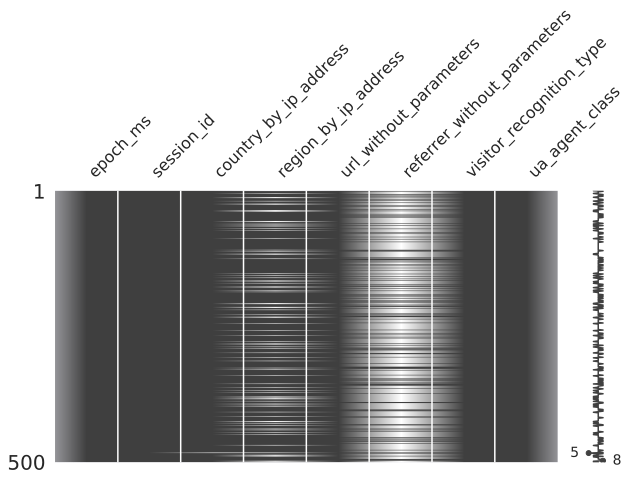

In [0]:
import missingno as msno

msno.matrix(df_bol.sample(500),
            figsize=(10, 5),
            width_ratios=(15, 1))

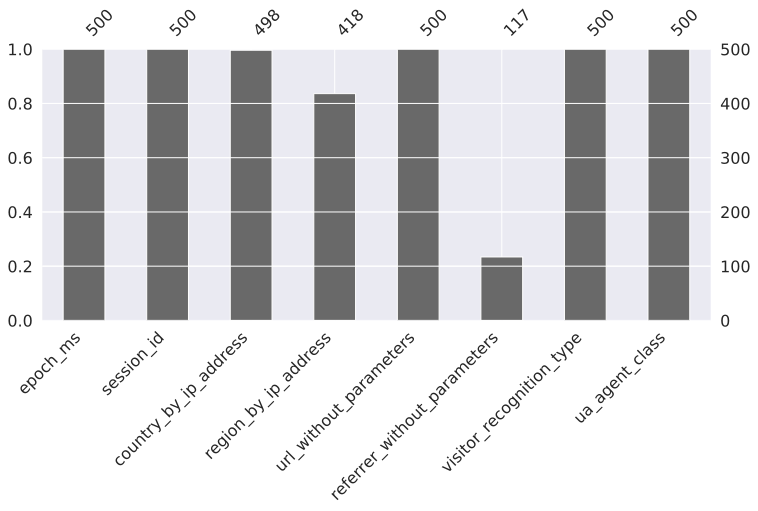

In [0]:
msno.bar(df_bol.sample(500),
            figsize=(12, 5),)

In [0]:
def summary_missing(dataset):
    n_miss = dataset.isnull().sum()
    n_obs = dataset.shape[0]
    n_miss_per = n_miss/n_obs*100
    n_miss_tbl = pd.concat([n_miss, n_miss_per], axis = 1).sort_values(1, ascending = False).round(1)
    n_miss_tbl = n_miss_tbl[n_miss_tbl[1] != 0]
    print('No. of fields: ', dataset.shape[0])
    print('No. of missing fields: ', n_miss_tbl.shape[0])
    n_miss_tbl = n_miss_tbl.rename(columns = {0:'No. of mising Value', 1:'%age of missing Value'})
    return n_miss_tbl

In [0]:
summary_missing(df_bol)

No. of fields:  12466
No. of missing fields:  3


,No. of mising Value,%age of missing Value
referrer_without_parameters,9365,75.1
region_by_ip_address,2090,16.8
country_by_ip_address,47,0.4


In [0]:
# checking each feature one by one starting with "referrer_without_parameters"

df_bol['referrer_without_parameters'].value_counts(dropna=False).head()

NaN                                                                         9365
https://www.bol.com/nl/s/algemeen/zoekresultaten/sc/media_all/index.html     165
https://www.bol.com/nl/chckout/checkout.html                                  79
https://www.bol.com/nl/m/voordeel/sale-solden/index.html                      47
https://www.bol.com/nl/s/algemeen/zoekresultaten/index.html                   35
Name: referrer_without_parameters, dtype: int64

NaN                                                                         44778

In [0]:
df_bol['country_by_ip_address'].value_counts(dropna=False).head(8)

NL     5386
US     4652
BE     1622
GB      241
DE      138
CN       62
FR       55
NaN      47
Name: country_by_ip_address, dtype: int64

NaN      248

In [0]:
df_bol['region_by_ip_address'].value_counts(dropna=False).head()

CA     4232
NaN    2090
ZH      907
NH      876
VAN     489
Name: region_by_ip_address, dtype: int64

NaN     9896

In [0]:
# use the 'isnull' Series method to filter the DataFrame rows. 
df_bol[df_bol.country_by_ip_address.isnull()].head()

,epoch_ms,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type,ua_agent_class
44,1520280042769,ead0de034f327f2d65b1d3b6e1ccf3bd,NaN,NaN,https://www.bol.com/nl/p/stahlex-o10mm-140cm-a...,https://www.bol.com/nl/p/stahlex-o10mm-120cm-a...,ANONYMOUS,Browser
149,1520280121568,ead0de034f327f2d65b1d3b6e1ccf3bd,NaN,NaN,https://www.bol.com/nl/p/kettingslot-top-lock-...,NaN,ANONYMOUS,Browser
415,1520280294514,4a462ddfb4a61788864dd2db9d07a8df,NaN,NaN,https://www.bol.com/nl/l/mediaplayers/N/7114/,NaN,ANONYMOUS,Browser
961,1520280658423,465b8921f35bfb2dbbc4764c7fbe0572,NaN,NaN,https://www.bol.com/nl/l/alle-laptops/N/4770/,NaN,ANONYMOUS,Browser
987,1520280671831,1910b1489132245e4cd481260cc20362,NaN,NaN,https://www.bol.com/nl/l/kinderwagens/N/11274/,NaN,ANONYMOUS,Browser


**Filling missing value with "VARIOUS"**

We could either remove these missing values or we might fill them with an "entity". If it were numerical data then I would use impute option. As it is categorical data , we might add"various" or as training model suggests , we may also add ''.

In [0]:
df_bol['referrer_without_parameters'].fillna(value='VARIOUS', inplace=True)
df_bol['country_by_ip_address'].fillna(value='VARIOUS', inplace=True)
df_bol['region_by_ip_address'].fillna(value='VARIOUS', inplace=True)

In [0]:
summary_missing(df_bol)

No. of fields:  12466
No. of missing fields:  0


,No. of mising Value,%age of missing Value


Seems fine now

In [0]:
df_bol['referrer_without_parameters'].value_counts(dropna=False).head()

VARIOUS                                                                     9365
https://www.bol.com/nl/s/algemeen/zoekresultaten/sc/media_all/index.html     165
https://www.bol.com/nl/chckout/checkout.html                                  79
https://www.bol.com/nl/m/voordeel/sale-solden/index.html                      47
https://www.bol.com/nl/s/algemeen/zoekresultaten/index.html                   35
Name: referrer_without_parameters, dtype: int64

In [0]:
df_bol.shape

(12466, 8)

And we didnt lose any values

### 3.3)-checking duplicate values

In [0]:
print(df_bol.duplicated().sum())

0


### 3.4)-Sorting

In [0]:
df_bol.sort_values(by='visitor_recognition_type', ascending=False).head()

,epoch_ms,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type,ua_agent_class
8835,1520280216443,bb976bcef4c1aace5789a89436a42fff,NL,VARIOUS,https://www.bol.com/nl/p/crosslinq-crosstape-l...,VARIOUS,RECOGNIZED,Browser
9346,1520280575855,401969f5ad79834110f2b96a46bd9661,NL,ZH,https://www.bol.com/nl/s/ajax/index.html,https://www.bol.com/nl/s/baby/zoekresultaten/N...,RECOGNIZED,Browser
4443,1520283135408,d9226d47f95ae69c0bbc76b5bd3982ab,NL,ZH,https://www.bol.com/nl/p/dyson-v10-absolute-st...,https://www.bol.com/nl/p/philips-powerpro-aqua...,RECOGNIZED,Browser
4442,1520283134163,ae77d18aa5b932ac0e9628e0e185e401,BE,VOV,https://www.bol.com/nl/s/ajax/index.html,https://www.bol.com/nl/s/sport-vrije-tijd/zoek...,RECOGNIZED,Browser
4440,1520283131781,4d87deed9ae903fa26a84d20ffdbc8d8,NL,ZH,https://www.bol.com/nl/p/lucide-goosy-soft-han...,VARIOUS,RECOGNIZED,Browser


In [0]:
df_bol.sort_values(by=['ua_agent_class', 'visitor_recognition_type'], ascending=[True, False]).head()

,epoch_ms,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type,ua_agent_class
9,1520280013619,d3828e7e2638881c9b0f3bed0221f815,NL,ZH,https://www.bol.com/nl/t/elektronica/audio-hif...,VARIOUS,RECOGNIZED,Browser
19,1520280023995,6c3d7350dee7687fe8a550951ae2ad4a,NL,ZH,https://www.bol.com/nl/checkout/login.html,VARIOUS,RECOGNIZED,Browser
26,1520280033070,160fdd31c0a5ecfb6e27d0c9e99eceaa,NL,UT,https://www.bol.com/nl/p/ducksday-zomer-poncho...,https://www.bol.com/nl/s/algemeen/zoekresultat...,RECOGNIZED,Browser
37,1520280038110,13f24291bd85342a43c4afbdad7c6e9c,NL,GR,https://www.bol.com/nl/ra/boeken/gratis-verzen...,VARIOUS,RECOGNIZED,Browser
39,1520280039188,8e2499565ca2b5a8a1ece6080e09af5d,NL,NB,https://www.bol.com/nl/c/ajax/index.html,VARIOUS,RECOGNIZED,Browser


### groupby

In [0]:
df_bol.groupby(['ua_agent_class']).count()

,epoch_ms,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type
ua_agent_class,,,,,,,
Browser,7461,7461,7461,7461,7461,7461,7461
Browser Webview,391,391,391,391,391,391,391
Cloud Application,2,2,2,2,2,2,2
Hacker,241,241,241,241,241,241,241
Mobile App,4,4,4,4,4,4,4
Robot,3309,3309,3309,3309,3309,3309,3309
Robot Mobile,1029,1029,1029,1029,1029,1029,1029
Special,28,28,28,28,28,28,28


In [0]:
df_bol.groupby(['ua_agent_class', 'visitor_recognition_type']).count()

epoch_ms  ...  referrer_without_parameters
ua_agent_class    visitor_recognition_type            ...                             
Browser           ANONYMOUS                     4350  ...                         4350
                  LOGGEDIN                       614  ...                          614
                  RECOGNIZED                    2497  ...                         2497
Browser Webview   ANONYMOUS                      184  ...                          184
                  LOGGEDIN                        87  ...                           87
                  RECOGNIZED                     120  ...                          120
Cloud Application ANONYMOUS                        2  ...                            2
Hacker            ANONYMOUS                      241  ...                          241
Mobile App        ANONYMOUS                        4  ...                            4
Robot             ANONYMOUS                     3309  ...                         3309
Robot Mobile      ANONYMOUS                     1029  ...                         1029
Special           ANONYMOUS                       28  ...                           28

[12 rows x 6 columns]

### 3.4)- Checking categorical features

In [0]:
# Checking unique categorical variables
df_bol.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

session_id                     7937
country_by_ip_address            51
region_by_ip_address            165
url_without_parameters         9325
referrer_without_parameters    1839
visitor_recognition_type          3
ua_agent_class                    8
dtype: int64

Our feature of interests are "ua_agent" being our independant feature, country_by_ip_address, region_by_ip_address and visitor_recognition_type.

In [0]:
# checking how many unique labels are in each feature
df_bol['visitor_recognition_type'].unique()

array(['ANONYMOUS', 'LOGGEDIN', 'RECOGNIZED', nan], dtype=object)

In [0]:
# how many times those labels classes occur
df_bol['visitor_recognition_type'].value_counts()

ANONYMOUS     9147
RECOGNIZED    2617
LOGGEDIN       701
Name: visitor_recognition_type, dtype: int64

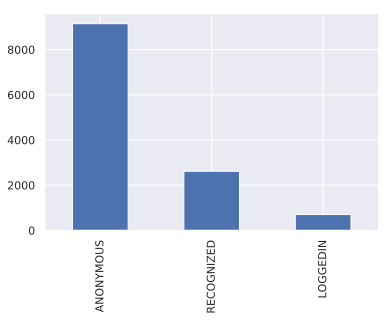

In [0]:
df_bol['visitor_recognition_type'].value_counts().plot.bar()

In [0]:
# Let's check other categorical variables such as country_by_ip_address

df_bol['country_by_ip_address'].unique()

array(['US', 'IT', 'NL', 'BE', 'VARIOUS', 'UA', 'FR', 'DE', 'PL', 'CN',
       'IE', 'RU', 'GB', 'AT', 'HU', 'JP', 'CA', 'PT', 'ES', 'CH', 'LT',
       'ID', 'IN', 'TR', 'IR', 'MY', 'NZ', 'AU', 'TH', 'BD', 'QA', 'CZ',
       'VN', 'MN', 'IL', 'FI', 'AM', 'DK', 'SR', 'GR', 'SE', 'LV', 'PK',
       'LU', 'MA', 'MD', 'BG', 'BR', 'HR', 'AR', 'AL'], dtype=object)

In [0]:
df_bol['country_by_ip_address'].value_counts()[:10]

NL         5386
US         4652
BE         1622
GB          241
DE          138
CN           62
FR           55
VARIOUS      47
UA           33
RU           22
Name: country_by_ip_address, dtype: int64

In [0]:
df_bol['region_by_ip_address'].unique()

array(['CA', 'LI', 'NB', 'UT', 'ZH', 'VARIOUS', 'GE', 'DR', 'GR', 'FL',
       'BRU', 'VAN', 'NH', 'OV', 'SO', 'VLI', 'FR', 'OK', '30', 'VWV',
       'BW', 'MZ', 'BJ', 'ZE', 'VOV', 'VBR', 'L', 'VLA', 'BOL', 'WA', '7',
       '5', 'AZ', 'NY', 'PA', 'VA', 'BU', 'ENG', 'WHT', 'TN', '13', 'IL',
       'NV', '69', 'WNA', 'AL', 'IN', 'ON', 'WLG', 'NJ', 'MN', '11', 'ND',
       'AR', 'DA', 'RM', 'QC', 'SD', 'TOM', 'ZG', '05', 'JI', 'HE', 'AP',
       '59', 'CO', '08', '67', '03', '35', 'WBR', '14', 'AUK', 'NSW',
       '64', 'MOS', '23', 'MD', 'ZP', '10', 'IA', 'LU', 'LA', '29', 'KP',
       'HN', '1', 'NYK', 'TA', '18', 'BA', 'ER', '27', '07', '81', 'TX',
       'NW', 'IRK', 'CM', 'MI', '40', 'I', 'JK', 'SI', 'GA', '26', 'OR',
       'MS', '24', '71', 'WKO', '9', 'NC', 'VGG', 'AB', 'LK', 'MOW',
       'RIX', 'PB', 'M', 'ME', 'SL', 'KHE', 'OH', 'ID', 'CT', 'MO', 'MA',
       '6', 'NI', '12', 'GRE', 'BY', '92', 'CU', 'CAS', '20', 'A', 'GI',
       'SH', 'FI', 'SRY', 'BE', 'WI', 'NFK', 'ULY', '

In [0]:
df_bol['region_by_ip_address'].value_counts()[:10]

CA         4232
VARIOUS    2090
ZH          907
NH          876
VAN         489
NB          463
GE          408
UT          322
VOV         316
OV          204
Name: region_by_ip_address, dtype: int64

### 3.5)- Dependant Feature

In [0]:
df_bol['ua_agent_class'].unique()

array(['Robot', 'Browser', 'Robot Mobile', 'Browser Webview', 'Hacker',
       'Special', 'Mobile App', 'Cloud Application', nan], dtype=object)

In [0]:
df_bol.shape

(12466, 8)

I will choose to divide into only two categories according to our problem statement.Our categories are bot traffic coming  from search engines (NHT-search), other bot traffic (NHT-other) and human traffic (HT). 

- I will choose first a binary problem where we have only Non-human traffice and Human traffice.

- Second case will be for three classes where traffic coming  from search engines (NHT-search), other bot traffic (NHT-other) and human traffic (HT) will be considered

**I am not sure about what special is. So, I ll remove it from our category**

In [0]:
df_bol = df_bol[~df_bol['ua_agent_class'].isin(['Special'])]
df_bol.shape

(12438, 8)

In [0]:
df_bol.ua_agent_class.value_counts()

Browser              7461
Robot                3309
Robot Mobile         1029
Browser Webview       391
Hacker                241
Mobile App              4
Cloud Application       2
Name: ua_agent_class, dtype: int64

In [0]:
df_bol['labels'] = df_bol.ua_agent_class.map({'Robot':'NHT', 'Robot Mobile':'NHT','Browser':'HT', 'Browser Webview':'HT','Hacker':'HT','Mobile App':'HT','Cloud Application':'HT'})

In [0]:
df_bol.labels.value_counts()

HT     8099
NHT    4338
Name: labels, dtype: int64

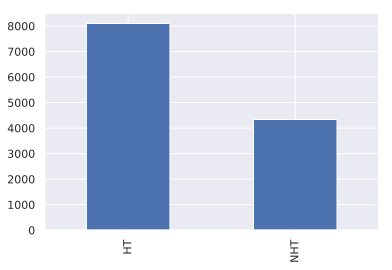

In [0]:
df_bol.labels.value_counts().plot(kind='bar')

### 3.6)-Checking relation with only one numerical variable

- epoch_ms: epoch in milliseconds

In [0]:
df_bol.describe()

,epoch_ms
count,1.243800e+04
mean,1.520283e+12
std,1.903252e+06
min,1.520280e+12
25%,1.520281e+12
50%,1.520282e+12
75%,1.520284e+12
max,1.520287e+12


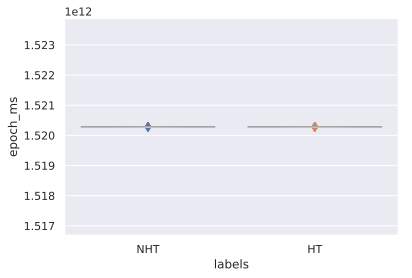

In [0]:
sns.boxenplot(x='labels',y='epoch_ms', data=df_bol)

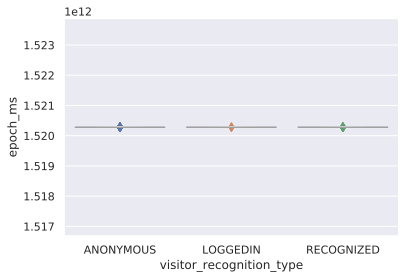

In [0]:
sns.boxenplot(x='visitor_recognition_type',y='epoch_ms', data=df_bol, hue='labels', palette='husl')

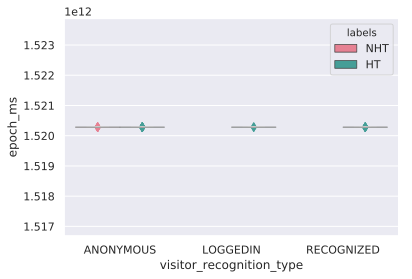

In [0]:
sns.boxenplot(x='visitor_recognition_type',y='epoch_ms', data=df_bol)

epoch_ms does not make much relation with other variables. So, we shall drop it in our analysis part.

# 4)- Creating dataframe with Feature of Importance

In [0]:
df_foi=df_bol[['labels','visitor_recognition_type','country_by_ip_address','region_by_ip_address']]

In [0]:
df_foi.head()

,labels,visitor_recognition_type,country_by_ip_address,region_by_ip_address
0,NHT,ANONYMOUS,US,CA
1,NHT,ANONYMOUS,US,CA
2,HT,ANONYMOUS,IT,LI
3,NHT,ANONYMOUS,US,CA
4,NHT,ANONYMOUS,US,CA


### 4a)-Checking ANONYMOUS traffice role in data
As we have now more concise data classification so, we might want to check again 

**This "ANONYMOUS" class in visitor_recognition_type feature is interesting. It could be that bot searches are mostly ANONYMOUS. It is only an assumption. Let's see if data supports it**

In [0]:
c=df_foi

In [0]:
c=c[(c.visitor_recognition_type == 'ANONYMOUS')]
c=c.groupby(['labels','visitor_recognition_type']).size()

In [0]:
c

labels  visitor_recognition_type
HT      ANONYMOUS                   4781
NHT     ANONYMOUS                   4338
dtype: int64

**There is not much difference. So, my assumption that "ANONYMOUS" is related to Non-human traffic does not hold ground.**


In [0]:
df_foi.groupby(['labels', 'visitor_recognition_type']).count()

country_by_ip_address  region_by_ip_address
labels visitor_recognition_type                                             
HT     ANONYMOUS                                  4781                  4781
       LOGGEDIN                                    701                   701
       RECOGNIZED                                 2617                  2617
NHT    ANONYMOUS                                  4338                  4338


one thing is for sure that all NHT is in ANONYMOUS category as seen above.

In [0]:
#df_foi.groupby(['labels', 'country_by_ip_address']).count()

# 4)- Saving file for future use


**Save file as pickle for binary classification**

In [0]:
df_foi.to_pickle('clickdata.pkl')